# Imports

In [4]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyxdf
from glob import glob

# Load Data

In [57]:
sub_files = glob('../../../Data/*/*.xdf')
sub_files

['../../../Data/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5942694/sub-P5942694_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5287460/sub-P5287460_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5813427/sub-P5813427_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5070899/sub-P5070899_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [58]:
sub_number = 3
xdf_path = sub_files[sub_number]
data, header = pyxdf.load_xdf(xdf_path, select_streams=[{'name':'OpenSignals'}, {'type': 'Markers'}])
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['Stimuli_Markers', 'OpenSignals']

In [59]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000

In [60]:
srate = PS['info']['effective_srate']

rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp = rsp_df.respiration

In [61]:
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

In [62]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df
# stim_df['time'] = stim_df['lsl_time_stamp'] - et_df['lsl_time_stamp'][0]

,trigger,event,lsl_time_stamp
0,2.000000e+02,Onset_Experiment,468121.675961
1,1.739809e+09,psychopy_time_stamp,468121.675970
2,1.000000e+01,Onset_RestingState,468153.774561
3,1.739810e+09,psychopy_time_stamp,468153.774569
4,1.100000e+01,Offset_RestingState,468453.774199
...,...,...,...
255,8.100000e+01,Offset_SocialTask,470285.559101
256,1.739812e+09,psychopy_time_stamp,470285.559116
257,2.010000e+02,Offset_Experiment,470290.556789
258,1.739812e+09,psychopy_time_stamp,470290.556802


# Compare Cleaning Methods

## Resting state

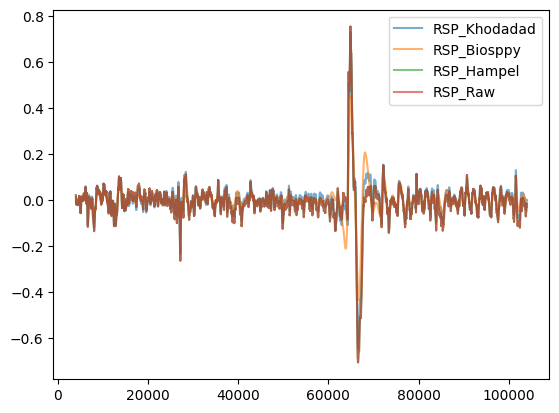

In [70]:
rsp = rsp_df.respiration
rsp = rsp[4000:104000] # 100000 samps / 500 samps/s = 200 seconds


signals = pd.DataFrame({
    "RSP_Khodadad": nk.rsp_clean(rsp, sampling_rate=srate, method="khodadad2018"),
    "RSP_Biosppy": nk.rsp_clean(rsp, sampling_rate=srate, method="biosppy"),
    "RSP_Hampel": nk.rsp_clean(rsp, sampling_rate=srate, method="hampel", threshold=3), 
    "RSP_Raw": rsp
})


ax = signals.plot(alpha = 0.6) # alpha = 0.6
# ax.get_lines()[signals.columns.get_loc("RSP_Raw")].set_alpha(0.5) # adjust alpha for one column

In [95]:
# rsp = rsp[1000:55000]

# signals2 = pd.DataFrame({
#     "RSP_Hampel": nk.rsp_clean(rsp, sampling_rate=srate, method="hampel", threshold=3), 
#     "RSP_Raw": rsp
# })


# ax = signals2.plot()
# ax.get_lines()[signals2.columns.get_loc("RSP_Raw")].set_alpha(0.5)

In [96]:
# SNR khodadad 
# cleaned signal
cleaned_khodadad = signals['RSP_Khodadad']

# signal power
signal_power_khodadad = np.var(cleaned_khodadad)

# noise signal
noise_signal_khodadad = rsp - cleaned_khodadad

# noise power
noise_power_khodadad = np.var(noise_signal_khodadad)

# snr
snr_khodadad = 10 * np.log10(signal_power_khodadad / noise_power_khodadad)
snr_khodadad

8.43087540602908

In [97]:
# SNR biosppy 
# cleaned signal
cleaned_biosppy = signals['RSP_Biosppy']

# signal power
signal_power_biosppy = np.var(cleaned_biosppy)

# noise signal
noise_signal_biosppy = rsp - cleaned_biosppy

# noise power
noise_power_biosppy = np.var(noise_signal_biosppy)

# snr
snr_biosppy = 10 * np.log10(signal_power_biosppy / noise_power_biosppy)
snr_biosppy


-1.431680659427299

In [98]:
# SNR hampel 
# cleaned signal
cleaned_hampel = signals['RSP_Hampel']

# signal power
signal_power_hampel = np.var(cleaned_hampel)

# noise signal
noise_signal_hampel = rsp - cleaned_hampel

# noise power
noise_power_hampel = np.var(noise_signal_hampel)

# snr
if noise_power_hampel == 0:
        snr_hampel = "no noise"
else:
    snr_hampel = 10 * np.log10(signal_power_hampel / noise_power_hampel)
snr_hampel


'no noise'

In [99]:
compare_snr = {'khodadad': snr_khodadad,
'biosppy': snr_biosppy,
'hampel': snr_hampel}

subject = sub_files[sub_number].split('/')[4].split('-')[1]
print("sub", subject, "#", sub_number)
compare_snr

sub P5548165 # 8


{'khodadad': 8.43087540602908,
 'biosppy': -1.431680659427299,
 'hampel': 'no noise'}

## Post-resting state 

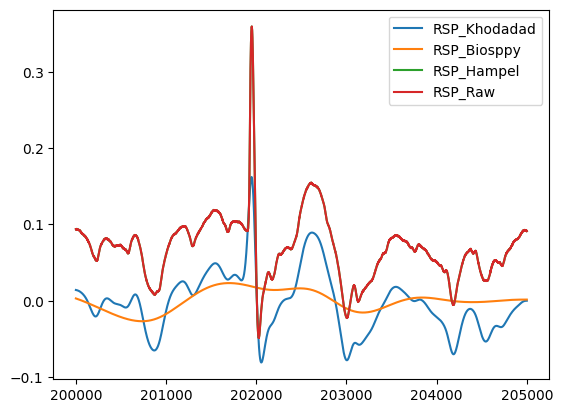

In [63]:
rsp = rsp_df.respiration
rsp_post_rest = rsp[200000:205000] # 10 seconds * 500 samps/s = 5000

signals = pd.DataFrame({
    "RSP_Khodadad": nk.rsp_clean(rsp_post_rest, sampling_rate=srate, method="khodadad2018"),
    "RSP_Biosppy": nk.rsp_clean(rsp_post_rest, sampling_rate=srate, method="biosppy"),
    "RSP_Hampel": nk.rsp_clean(rsp_post_rest, sampling_rate=srate, method="hampel", threshold=3), 
    "RSP_Raw": rsp_post_rest
})


ax = signals.plot() # alpha = 0.6
# ax.get_lines()[signals.columns.get_loc("RSP_Raw")].set_alpha(0.5) # adjust alpha for one column

In [64]:
# SNR khodadad 
# cleaned signal
cleaned_khodadad = signals['RSP_Khodadad']

# signal power
signal_power_khodadad = np.var(cleaned_khodadad)

# noise signal
noise_signal_khodadad = rsp - cleaned_khodadad

# noise power
noise_power_khodadad = np.var(noise_signal_khodadad)

# snr
snr_khodadad = 10 * np.log10(signal_power_khodadad / noise_power_khodadad)
snr_khodadad

8.819709403150663

In [65]:
# SNR biosppy 
# cleaned signal
cleaned_biosppy = signals['RSP_Biosppy']

# signal power
signal_power_biosppy = np.var(cleaned_biosppy)

# noise signal
noise_signal_biosppy = rsp - cleaned_biosppy

# noise power
noise_power_biosppy = np.var(noise_signal_biosppy)

# snr
snr_biosppy = 10 * np.log10(signal_power_biosppy / noise_power_biosppy)
snr_biosppy


-9.351668748644899

In [66]:
# SNR hampel 
# cleaned signal
cleaned_hampel = signals['RSP_Hampel']

# signal power
signal_power_hampel = np.var(cleaned_hampel)

# noise signal
noise_signal_hampel = rsp - cleaned_hampel

# noise power
noise_power_hampel = np.var(noise_signal_hampel)

# snr
if noise_power_hampel == 0:
        snr_hampel = "no noise"
else:
    snr_hampel = 10 * np.log10(signal_power_hampel / noise_power_hampel)
snr_hampel


'no noise'

In [67]:
compare_snr = {'khodadad': snr_khodadad,
'biosppy': snr_biosppy,
'hampel': snr_hampel}

subject = sub_files[sub_number].split('/')[4].split('-')[1]
print("sub", subject, "#", sub_number)
compare_snr

sub P5287460 # 3


{'khodadad': 8.819709403150663,
 'biosppy': -9.351668748644899,
 'hampel': 'no noise'}